<center>
<div class="alert alert-block alert-info">
<h1>Customer Segmentation</h1>
    </div>

<a id=menu></a>
## Menu
* [Import ](#imports)  
* [KMeans Clustring](#kmeans_clustering)
* [Distribution of Variables](#variable-distribution)
* [Apply Log Transformation](#apply_log)
* [Standardize Variables](#stadardscaler)
* [Apply Kmeans to Data](#kmeans)
* [Create Customer Segemnts](#dataframe_seg)
* [Run PCA on Kmeans](#pca)
* [Hierarchical Clusterning](#hierarchical_clustering)

<a id=imports></a>
### Imports

In [515]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
from IPython.display import display, HTML

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [25]:
os.listdir('../cleaned_data')


['rfm_data.csv', 'clean_sales_df.csv', 'rfm_data.pkl', 'clean_sales_df.json']

In [157]:
#import file
data_path = '../cleaned_data'
file_path = '/rfm_data.csv'

In [160]:
data_rfm = pd.read_csv(data_path + file_path, index_col=0)
data_rfm.head()

,Customer ID,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,segment_label
0,12346,529,24,169.36,1,2,1,121,4,Bronze
1,12347,2,221,4671.93,4,4,4,444,12,Gold
2,12348,249,27,421.76,2,2,2,222,6,Silver
3,12349,19,170,3498.94,4,4,4,444,12,Gold
4,12350,310,16,294.40,2,1,1,211,4,Bronze


In [161]:
#create a data frame with only recency, frequency and monetary value
data = data_rfm[['Customer ID','Recency','Frequency','MonetaryValue']]
data.head()

,Customer ID,Recency,Frequency,MonetaryValue
0,12346,529,24,169.36
1,12347,2,221,4671.93
2,12348,249,27,421.76
3,12349,19,170,3498.94
4,12350,310,16,294.40


In [162]:
#set the index to be the customer id
data.set_index('Customer ID', inplace=True)
print(data.shape)
data.head()

(5731, 3)


,Recency,Frequency,MonetaryValue
Customer ID,,,
12346,529,24,169.36
12347,2,221,4671.93
12348,249,27,421.76
12349,19,170,3498.94
12350,310,16,294.40


<a id=kmeans_clustering></a>
### Kmeans Clustering

Clustering is used to find similar data points within the same cluster, and this helps the business to use targeted marketing. Clustering is very important because it impacts the business strategy.  

I will use Kmeans clustering to cluster customers according to their purchase history and past activities. It is the most used clustering algorithm because it is easy to use. Kmeans is a centroid based algorithm, which means it minimizes the distances between points and their centroid

However, kmeans requires some data preprocessing.  

1. it requires that all the features have symmetric distribution, meaning no skewness
2. variables have the same average value, meaning their means are the same, so they are standardized: this ensures that each variable gets equal weight in the kmeans calculation.
3. variables have the same variance.  


>First thing look at the descriptive stats for each variable 

In [163]:
data.describe()

,Recency,Frequency,MonetaryValue
count,5731.000000,5731.000000,5731.000000
mean,200.204676,130.234340,2059.803792
std,208.662652,330.453514,5530.795971
min,1.000000,1.000000,2.900000
25%,26.000000,21.000000,315.330000
50%,95.000000,52.000000,780.590000
75%,379.000000,136.000000,1980.625000
max,738.000000,12210.000000,238941.540000


>The three variables have very different variance and mean.  



<a id=variable-distribution></a>
### Distribution of Variables

Steps to be taken for kmeans to work
1. normalize the data like using log transformation, which makes the data less sensitive to outliers. This has to be done before because standardizing will produce negative numbers, to which we can't apply the log transformation on.
2. scale data using standardscale
3. store these new variables in separate array because once clustering is done, I need the original values to calculate some stats on each cluster

>Now look at the distributions

In [164]:
#define a function that takes the data and plots the variables, recency, Frequency and monetary value
def plot_rfm(data,title):
    sns.set_style('darkgrid')
    plt.style.use('fivethirtyeight')


    f,ax = plt.subplots(3,1,figsize=(10,7))
    f.suptitle(title)

    sns.distplot(data['Recency'],ax=ax[0],label='Recency')
    #ax[0].set_title('Recency')
    ax[0].set_xlabel(None)
    ax[0].legend()

    sns.distplot(data['Frequency'],ax=ax[1],label='Frequency',color='orange')
    #ax[1].set_title('Frequency')
    ax[1].set_xlabel(None)
    ax[1].legend()

    sns.distplot(data['MonetaryValue'],ax=ax[2],label = 'Monetary Value',color='green')
    #ax[2].set_title('Monetary Value')
    ax[2].set_xlabel(None)
    ax[2].legend()

    plt.tight_layout()

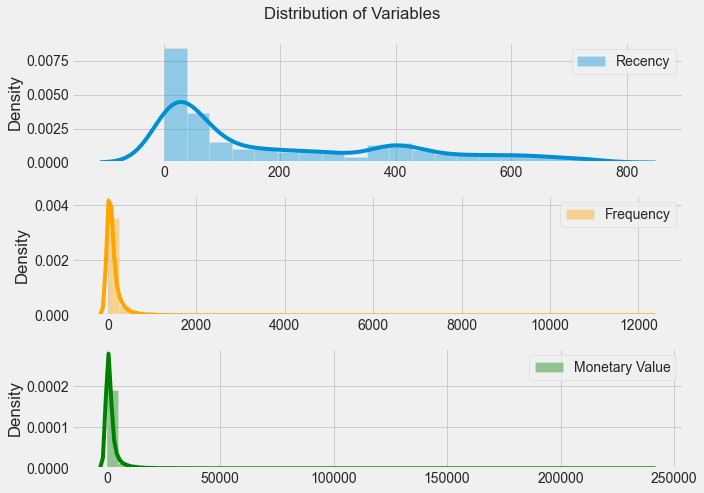

In [165]:
#call plot function
plot_rfm(data, 'Distribution of Variables')


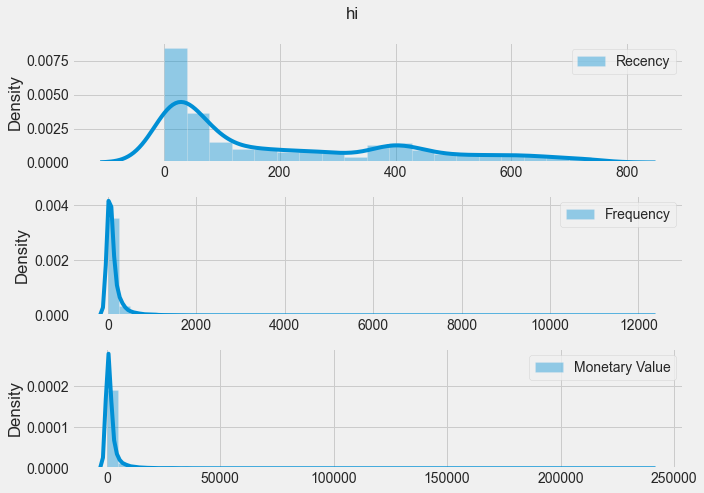

In [134]:
#Plot each variable
sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')


f,ax = plt.subplots(3,1,figsize=(10,7))

sns.distplot(data['Recency'],ax=ax[0],label='Recency')
#ax[0].set_title('Recency')
ax[0].set_xlabel(None)
ax[0].legend()

sns.distplot(data['Frequency'],ax=ax[1],label='Frequency')
#ax[1].set_title('Frequency')
ax[1].set_xlabel(None)
ax[1].legend()

sns.distplot(data['MonetaryValue'],ax=ax[2],label = 'Monetary Value')
#ax[2].set_title('Monetary Value')
ax[2].set_xlabel(None)
ax[2].legend()

plt.tight_layout()

>All the distributions are skewed to the right. Recency has a long right tail, frequency most of the values are between 0 and 100 and there is a very long tail where values go up to 12000, same thing for density, where there is a very long tail that goes up to 250000
One way to fix that is to apply logarithmic transformation. This works for only positive values, so if there are negative values, I could take the biggest one and subtract its absolute value from all the data and add 1, which ensures that the values are above zero. Fortunately, my data is all positive.

>Skewness can be measured by the skew() method, which shows the asymmetry of a distribution. Normal distribution has skewness equal to 0. If the skewness is between -0.5 and 0.5, the data are fairly symmetrical


<AxesSubplot:>

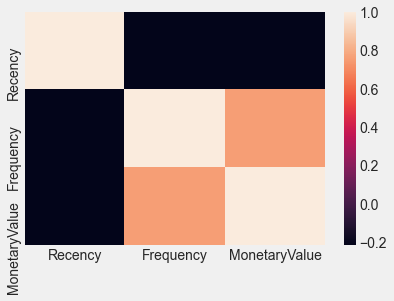

In [326]:
sns.heatmap(data.corr())

<a id=apply_log></a>
### Apply Log Transformation

In [166]:
#measure skewness
data.skew(axis=0)#across columns

Recency           0.895357
Frequency        18.470250
MonetaryValue    19.263475
dtype: float64

In [167]:
#perform log transformation on data
data_log = np.log(data)
#measure skewness again
data_log.skew(axis=0)

Recency         -0.613002
Frequency       -0.136882
MonetaryValue    0.080849
dtype: float64

>recency is still skewed but now to the left. I will try log1p which is log(1+x)

In [179]:
#take the log(x+1) of variables
data_logp = np.log1p(data)
#measure skew
data_logp.skew(axis=0)

Recency         -0.483442
Frequency        0.034652
MonetaryValue    0.098873
dtype: float64

>Log1p gives better skewness, now all variables are between -0.5 and 0.5, which means they are symmetric around the mean

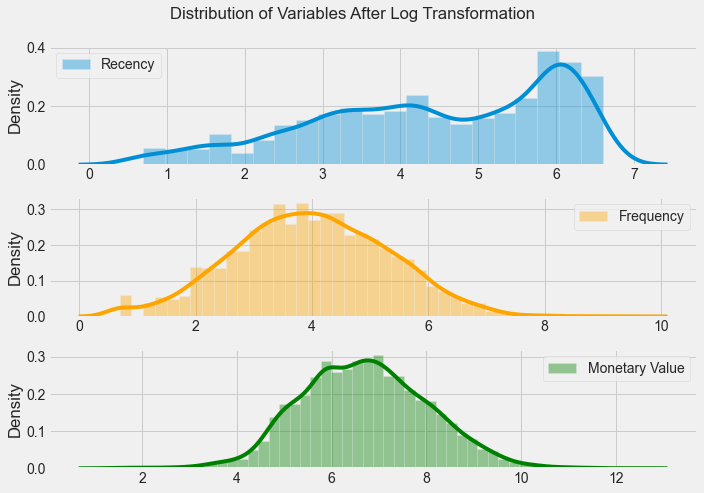

In [180]:
#call plot_rfm function to plot data
plot_rfm(data_logp,'Distribution of Variables After Log Transformation')



[Back to Menu](#menu)

<a id=stadardscaler></a>
### Standardize Variables

In [181]:
scaler = StandardScaler()
scaler.fit(data_logp)
data_normalized = scaler.transform(data_logp)

In [183]:
#a numpy array is returned after transform, so now put the data into a dataframe again
data_normalized_df = pd.DataFrame(data_normalized,index=data.index, columns=data.columns)
print(data_normalized_df.shape)
data_normalized_df.head()

(5731, 3)


,Recency,Frequency,MonetaryValue
Customer ID,,,
12346,1.171387,-0.581526,-1.162267
12347,-2.150579,1.066079,1.315167
12348,0.688965,-0.496023,-0.482325
12349,-0.932595,0.869153,1.098935
12350,0.829138,-0.872495,-0.750500


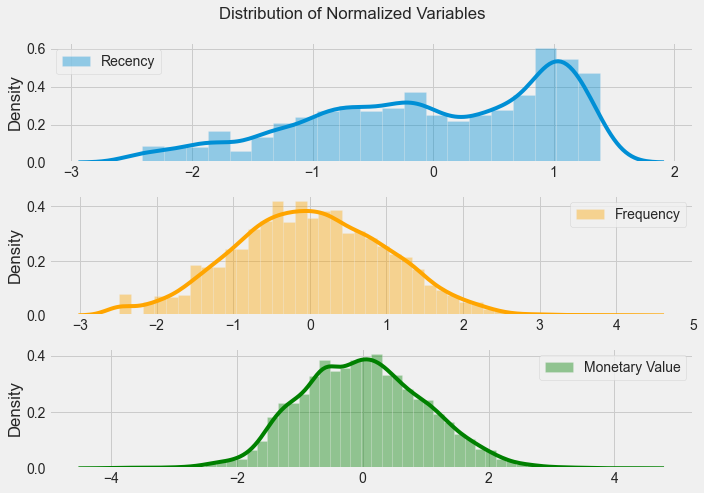

In [185]:
#now visualize
plot_rfm(data_normalized_df, 'Distribution of Normalized Variables')


[Back to Menu](#menu)

<a id=kmeans></a>
### Apply Kmeans to Data

>Kmeans is a cluster based algorithm where the data is partitioned into samples such that similar instances are grouped together in the same partition. We choose arbitrarily the number of clusters.
>>First I choose a range for the number of clusters, then use different metrics to measure quality of clusters. I want to maximize inter cluster similarities and minimize intra cluster similarities. There are three metrics to measure how good the clusters are: 
- The elbow method, which measures the within cluster sum of squares and plots it to see a point that looks like an elbow. 
- The Silhouette Index measure the distance between each data point, the centroid of the cluster it was assigned to and the closest centroid belonging to another cluster, (formula is b-a/max(a,b)), values close to 0 indicate overlapping clusters, and closer to 1 indicate a better separated dense clusters
- David Bouldin score evaluates intra-cluster similarity and inter-cluster differences. Lower value indicates a better model with better separation between clusters



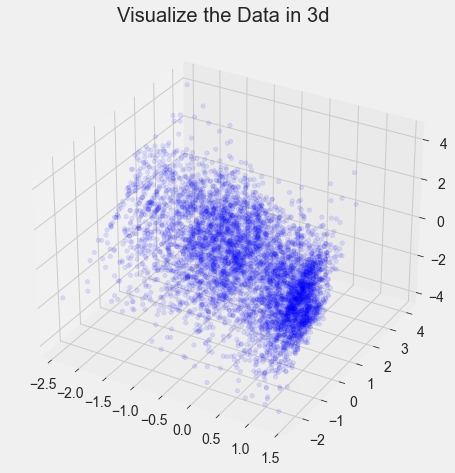

In [347]:
#visualize data in 3d to see if there is a pattern
plt.figure(figsize=(7,10))
ax = plt.axes(projection='3d')
ax.scatter(data_normalized_df.iloc[:,0],data_normalized_df.iloc[:,1],data_normalized_df.iloc[:,2],alpha=.1,color='blue')
ax.set_title('Visualize the Data in 3d ');

>There are some dense areas in the front and middle

In [343]:
#iterate through 0 to 10 clusters and create dictionries for sse(sum of squares error), davies_score, silhouette_score
sse, davies_sc, silh_sc = {},{},{}
nclusters = range(2,11)
for ncluster in nclusters:
    kmeans = KMeans(n_clusters = ncluster, random_state=123,max_iter=1000,init='k-means++')
    cluster_labels = kmeans.fit_predict(data_normalized)
    
   #sum of square distances to closest cluster center
    sse[ncluster] = kmeans.inertia_ 
    
    #measure the Davies Bouldin score ratio between the cluster scatter and the cluster’s separation 
    #and a lower value will mean that the clustering is better.
    davies_sc[ncluster] = davies_bouldin_score(data_normalized, cluster_labels)
    
    #the silhouette score gives the average value for all the samples
    #which gives a perspective into the separation and density of the clusters
    silh_sc[ncluster] = silhouette_score(data_normalized,cluster_labels)
    
    #compute the silhouette score for each sample, meaning the distance between the point and its centroid
    #and distance of point from closest cluster (b-a)/max(a,b) where a is inter centroid distance and b is intra centroid distance
    sample_silh_val = silhouette_samples(data_normalized,cluster_labels)
    


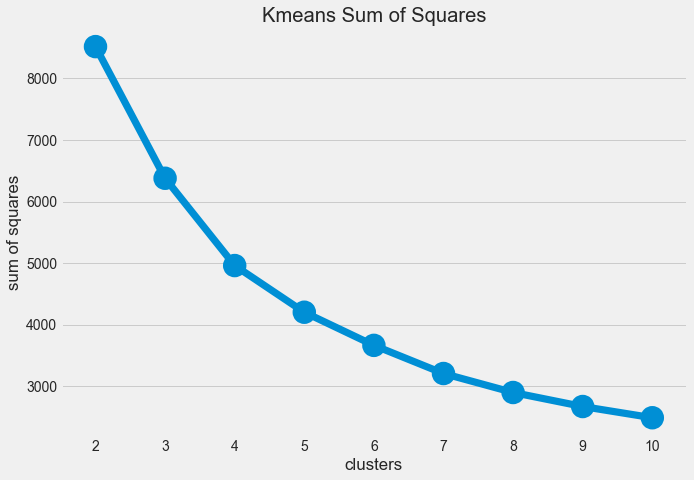

In [353]:
#graph sum of squares
plt.figure(figsize=(10,7))
sns.pointplot(list(sse.keys()),list(sse.values()))#, marker='o',markersize=15,linestyle='--',color='blue')
plt.title('Kmeans Sum of Squares')
plt.xlabel('clusters')
plt.ylabel('sum of squares');

>I need to minimize sum of squares. From the graph, it appears the best number of clusters is 4, 5 and 6. There is a  smooth decrease in sum of squares after 4.

Text(0, 0.5, 'score')

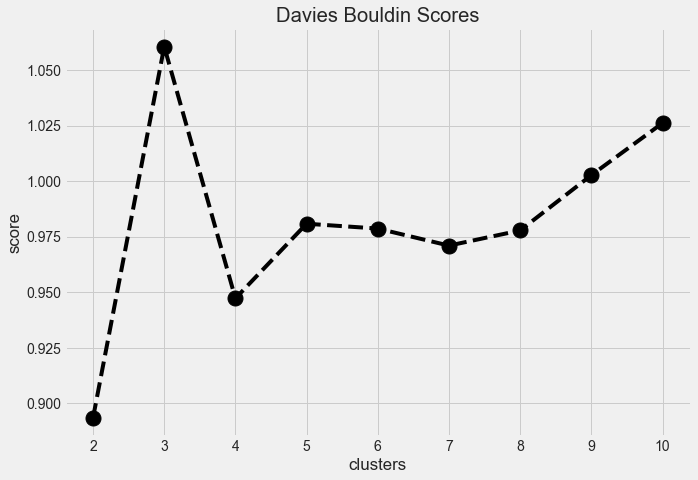

In [344]:
#graph Davies Bouldin score
plt.figure(figsize=(10,7))
plt.plot(list(davies_sc.keys()),list(davies_sc.values()), marker='o',markersize=15,linestyle='--',color='black')
plt.title('Davies Bouldin Scores')
plt.xlabel('clusters')
plt.ylabel('score')

>For Davies Bouldin we are looking for the lowest score, which is for cluster 4 on the graph. 

Text(0, 0.5, 'score')

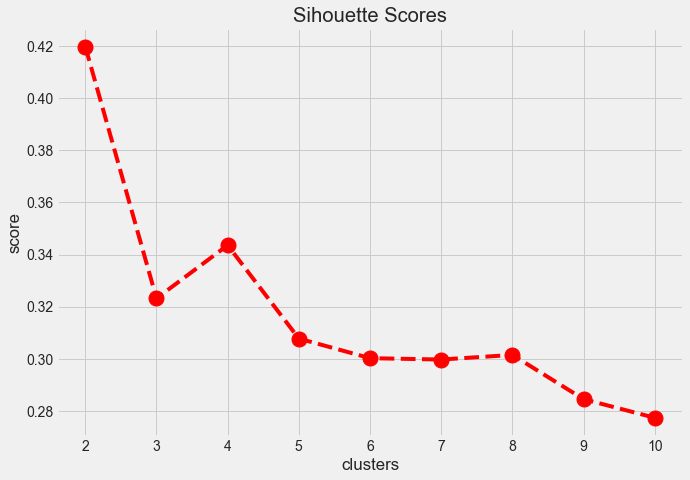

In [345]:
#graph silhouette scores
plt.figure(figsize=(10,7))
plt.plot(list(silh_sc.keys()),list(silh_sc.values()), marker='o',markersize=15,linestyle='--',color='red')
plt.title('Sihouette Scores')
plt.xlabel('clusters')
plt.ylabel('score')

>The Silhouette score measures the degree of separation between clusters. From the graph I see that the local maxima is at 4

For ncluster = 2 The average silhouette_score is : 0.41972161329672614
For ncluster = 3 The average silhouette_score is : 0.32322577628017024
For ncluster = 4 The average silhouette_score is : 0.34359793176570486
For ncluster = 5 The average silhouette_score is : 0.3078338751883995
For ncluster = 6 The average silhouette_score is : 0.3003135597228929
For ncluster = 7 The average silhouette_score is : 0.2997885727619264
For ncluster = 8 The average silhouette_score is : 0.3015621304605511
For ncluster = 9 The average silhouette_score is : 0.28460086777129484


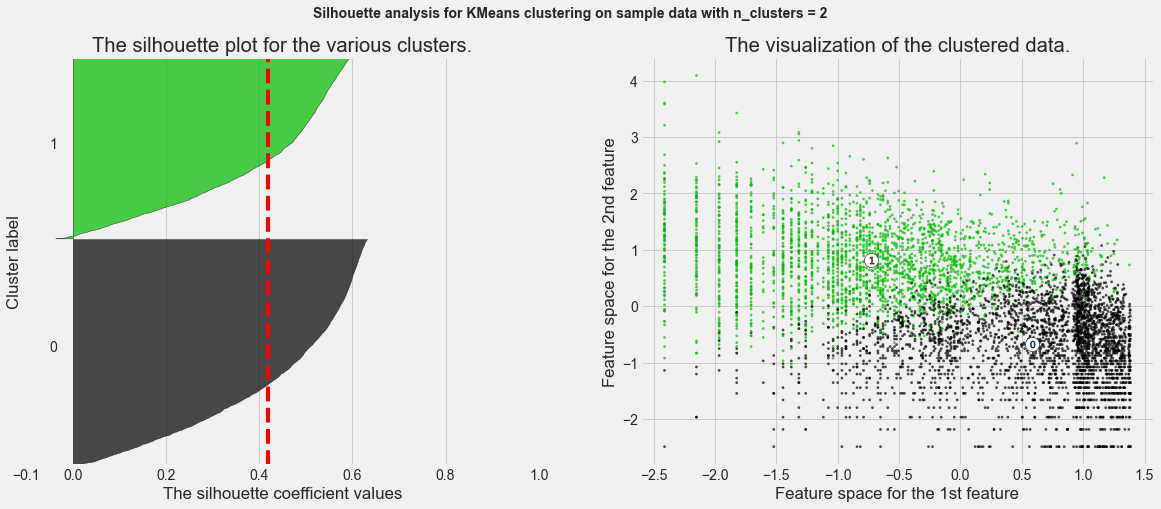

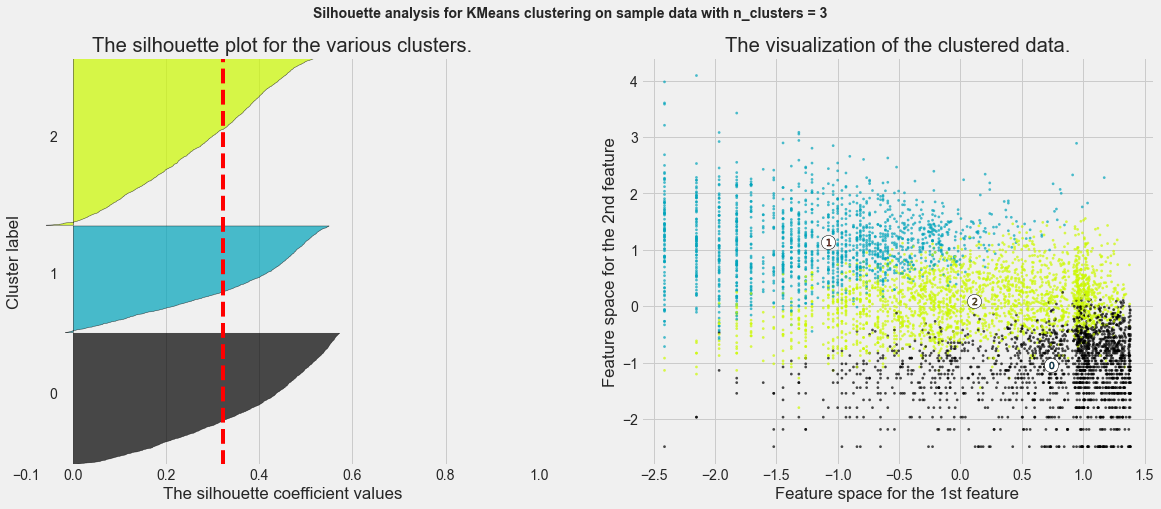

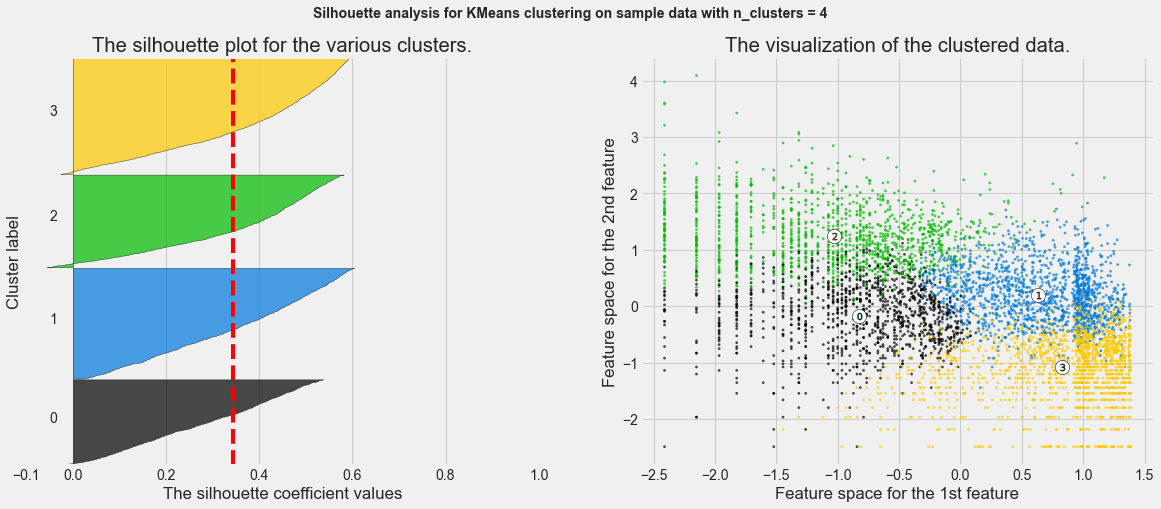

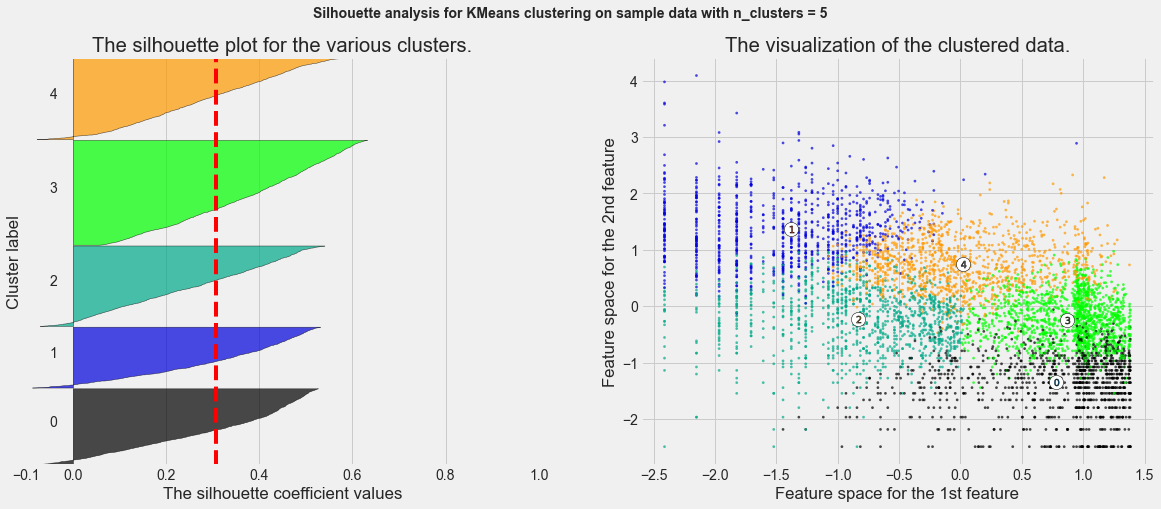

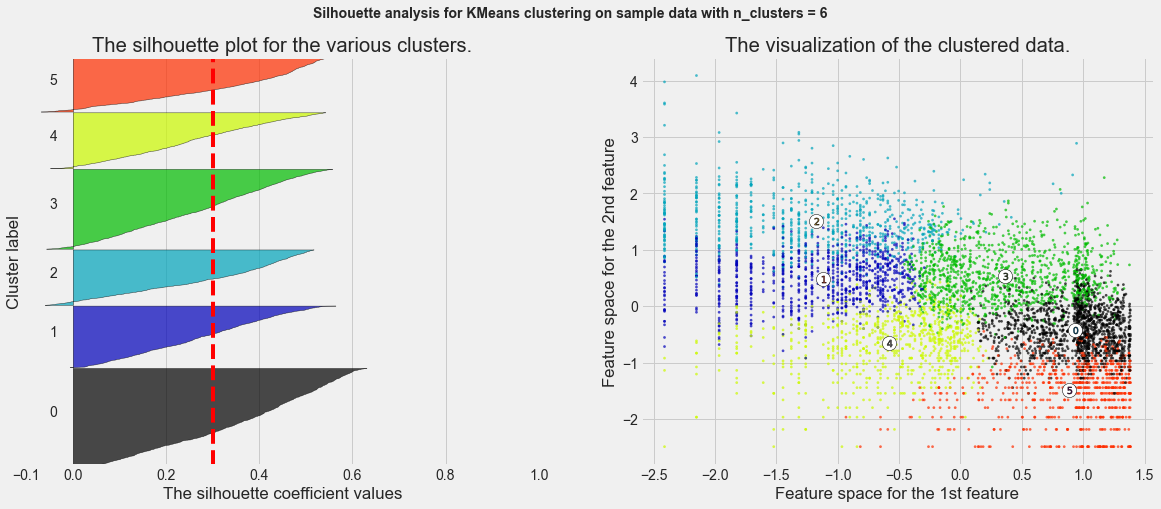

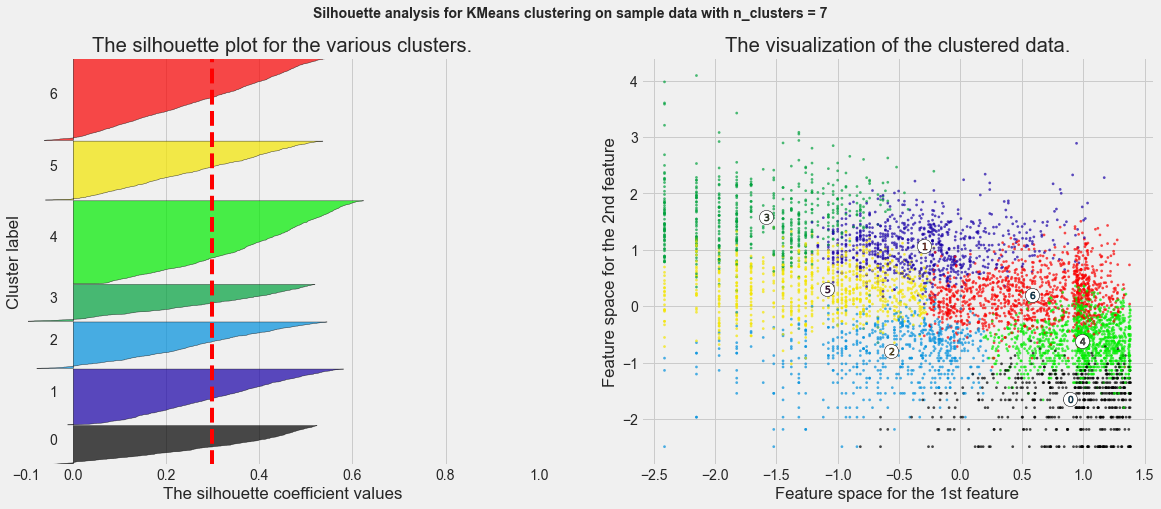

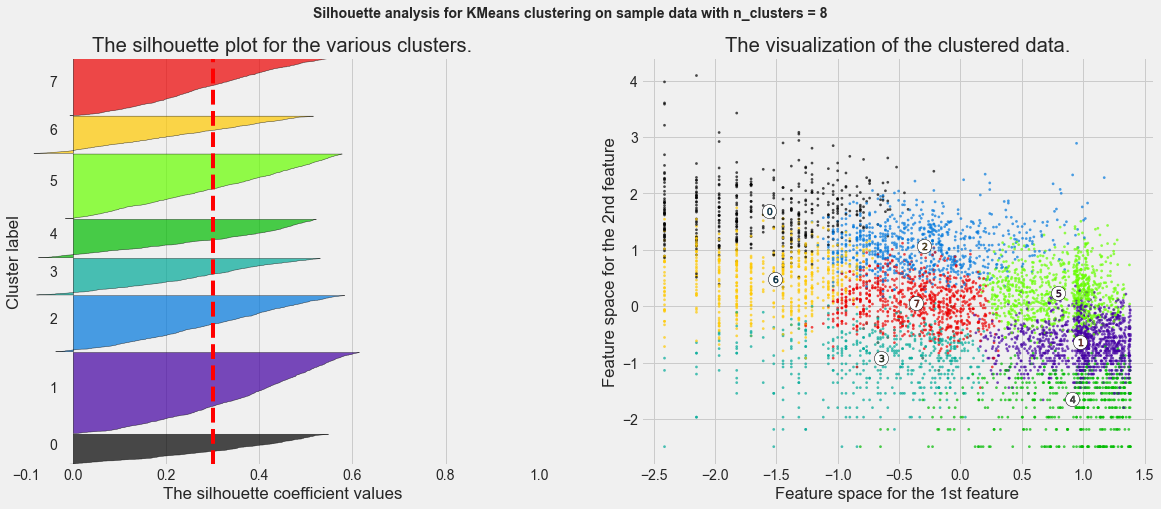

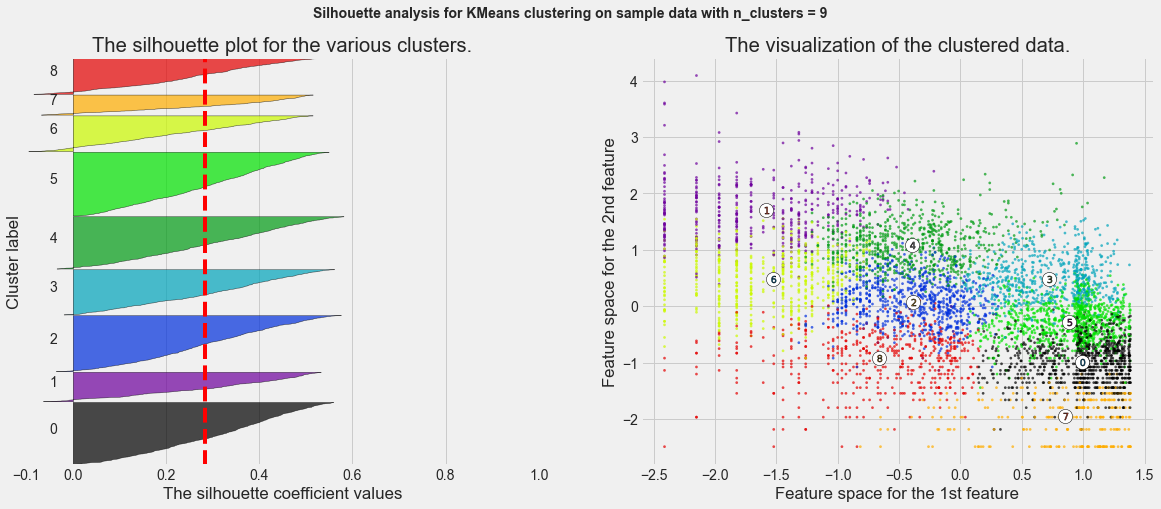

In [317]:
"""plot the silhouette plots clusters 
This code is taken from: 
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
"""
nclusters = range(2,10)
for ncluster in nclusters:

    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (ncluster+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters
    ax1.set_ylim([0, len(data_normalized) + (ncluster + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=ncluster, random_state=123)
    cluster_labels = kmeans.fit_predict(data_normalized)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_normalized, cluster_labels)
    print("For ncluster =", ncluster,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_normalized, cluster_labels)

    y_lower = 10
    for i in range(ncluster):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / ncluster)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor='black', alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / ncluster)
    ax2.scatter(data_normalized[:, 0], data_normalized[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % ncluster),
                 fontsize=14, fontweight='bold')


>All segments are above the average silhouette score, which confirms the sum of square results, meaning all the clusters are significant. So 4 segment could give me good results, but so does 5 and 6 etc. However further segmenting the data might give more information but it might be unnecessary and I am over fitting to the data.

[Back to Menu](#menu)

<a id=dataframe_seg></a>
### Create Customer Segemnts

>I will create a new dataframe with 4 and 5 segments to see which one segements my customers better

In [362]:
kmeans_4 = KMeans(n_clusters=4, random_state=123,max_iter=1000,init='k-means++')
labels_4  = kmeans.fit_predict(data_normalized)

In [363]:
kmeans_5 = KMeans(n_clusters=5, random_state=123,max_iter=1000,init='k-means++')
labels_5 = kmeans_5.fit_predict(data_normalized)

In [447]:
data_segmented_4 = data.assign(Group = labels_4)
data_segmented_4.head()

,Recency,Frequency,MonetaryValue,Group
Customer ID,,,,
12346,529,24,169.36,3
12347,2,221,4671.93,2
12348,249,27,421.76,3
12349,19,170,3498.94,2
12350,310,16,294.40,3


In [529]:
data_path

'../cleaned_data'

In [530]:
#save the data
data_segmented_4.to_csv(data_path+'/kmeans_4_groups.csv')

In [448]:
data_segmented_5 = data.assign(Group=labels_5)
data_segmented_5.head()

,Recency,Frequency,MonetaryValue,Group
Customer ID,,,,
12346,529,24,169.36,0
12347,2,221,4671.93,1
12348,249,27,421.76,3
12349,19,170,3498.94,1
12350,310,16,294.40,0


In [532]:
#calculate the average rfm values and count for each segment
group_4 = data_segmented_4.groupby('Group')
group_4.agg({'Recency':'mean',
            'Frequency':'mean',
            'MonetaryValue':['mean','count']}).round(0)

Recency Frequency MonetaryValue      
         mean      mean          mean count
Group                                      
0        31.0      55.0         770.0  1207
1       279.0      88.0        1310.0  1568
2        29.0     395.0        6434.0  1311
3       386.0      15.0         235.0  1645

>The group that spends the most is group 2, they are also quite active with the mean of their most recent transaction was 29 days ago. This is the most important group since it spends the most and are active. 
The next group is group 1 that has the second highest value, but they are not very active so the company could offer them some promotions and specials to get them to become more active. Group 3 is the least active group and they spend the least so the company could send them more offers and promotions to get them to become more active.

In [533]:
group_5 = data_segmented_5.groupby('Group')
group_5.agg({'Recency':'mean',
            'Frequency':'mean',
            'MonetaryValue':['mean','count']})

Recency   Frequency MonetaryValue      
             mean        mean          mean count
Group                                            
0      372.401109   10.207948    170.971747  1082
1       13.625000  476.668981   7864.723252   864
2       31.256567   49.408932    709.917364  1142
3      370.622984   44.675403    653.995948  1488
4      125.957576  173.665801   2632.685377  1155

>5 segments give more information. The most important customer segment is in segment 1, with the highest spending and activity. 

<a id=pca></a>
### Run PCA with Kmeans

>To be able to visualize the segments, reduce the dimensionality of the data using pca

In [449]:
#run pca to reduce dimentionality 
pca = PCA()
pca_comp = pca.fit_transform(data_normalized)
pca_comp

array([[-1.64851549, -0.42957209,  0.39881034],
       [ 2.51873717,  1.06043484, -0.15039047],
       [-0.93980978, -0.26424043, -0.01684004],
       ...,
       [-2.08973531, -0.33784266, -0.04974879],
       [-0.27170834, -1.1118391 , -0.11339524],
       [ 1.43753382, -0.30797704, -0.29945788]])

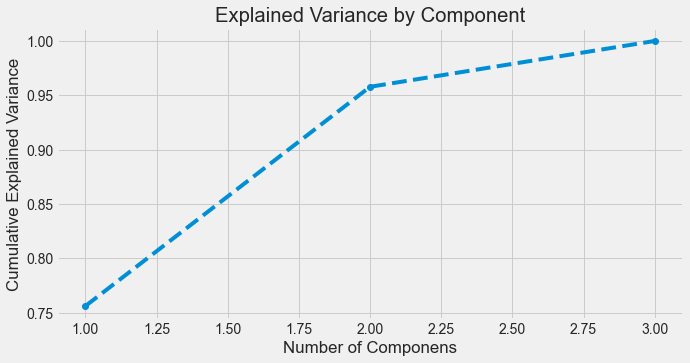

In [450]:
features = range(1,pca.n_components_+1)
plt.figure(figsize = (10,5))
plt.plot(features,pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
#plt.bar(features,pca.explained_variance_ratio_)
plt.title('Explained Variance by Component')
plt.xlabel('Number of Componens')
plt.ylabel('Cumulative Explained Variance');

In [451]:
#there is a clear elbow where 2 components explain more that 95% of the data
#run pca with 2 components and add the 4 cluster labels to the data
pca_comp_2 = PCA(n_components=2).fit_transform(data_normalized)
pca_df = pd.DataFrame(data=pca_comp_2,columns = ['pc1','pc2'])

In [452]:
pca_df = pca_df.assign(Group=labels_4)
pca_df.head()

,pc1,pc2,Group
0,-1.648515,-0.429572,3
1,2.518737,1.060435,2
2,-0.939810,-0.264240,3
3,1.670065,0.139162,2
4,-1.405985,-0.163075,3


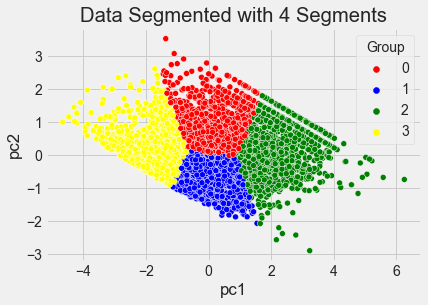

In [454]:
#visualize the segments in 2d using pca for easier visualizing 
sns.scatterplot(x='pc1',y='pc2',hue='Group',data=pca_df,palette=['red','blue','green','yellow'])
plt.title('Data Segmented with 4 Segments');

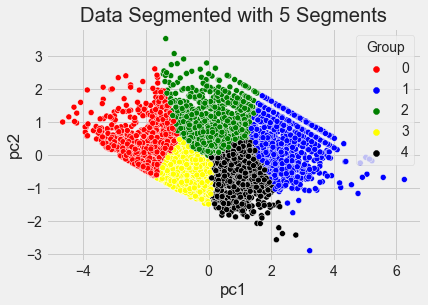

In [456]:
#visualize the 5 segments
pca_df_5 = pca_df.assign(Group=labels_5)
pca_df.head()
sns.scatterplot(x='pc1',y='pc2',hue='Group',data=pca_df_5,palette=['red','blue','green','yellow','black'])
plt.title('Data Segmented with 5 Segments');

> 4 segments cuts the data nicely, 5 segments only further segments segment 1 and segment 3. Segment 0 and 2 are not affected

[Back to Menu](#menu)

<a id=hierarchical_clustering></a>
### Hierarchical Clustering

To get more insight on the clusters, I will use hierarchical clustering.
Hierarchical clustering also groups customers according to their behavior. It starts by making each point, or customer its own segment, then it combines the closest segments using the euclidean distance between points, and continues to merge segments until there is one big segment. The final number of segments is obtained by crossing the longest distance with a line and counting the segments. There are many methods of measuring distance. There is single linkage, which measures the shortest distance between points in clusters, or average linkage, which measures the average distance between points in different clusters. I will use ward linkage which analysis the variance of clusters.

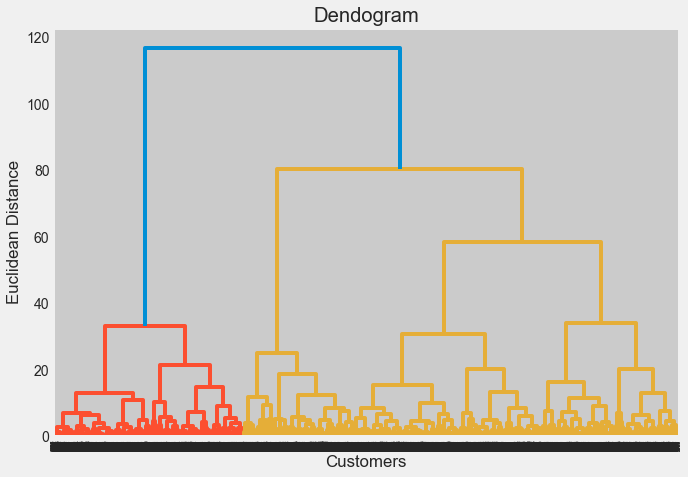

In [431]:
#create a dendogram of the segemnts using the ward method
plt.figure(figsize=(10,7))
dist1 = hierarchy.linkage(data_normalized,method='ward')
dendogram = hierarchy.dendrogram(dist)
plt.title('Dendogram')
plt.ylabel('Euclidean Distance')
plt.xlabel('Customers');


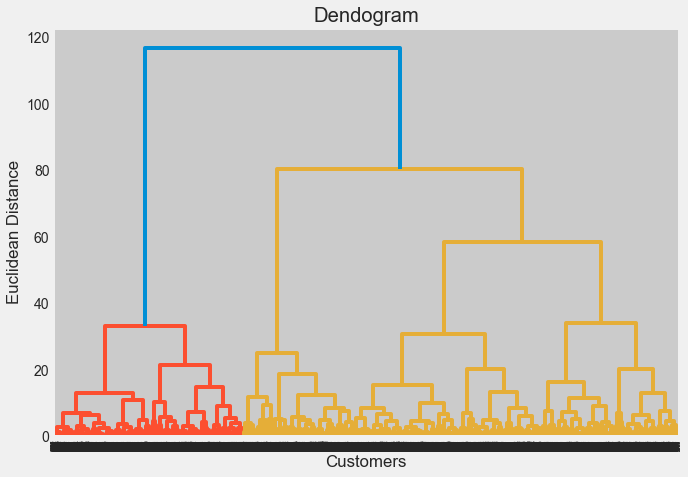

In [435]:
#dendogram using average linkage method
plt.figure(figsize=(10,7))
dist2 = hierarchy.linkage(data_normalized,method='average')
dendogram = hierarchy.dendrogram(dist)
plt.title('Dendogram')
plt.ylabel('Euclidean Distance')
plt.xlabel('Customers');


>There is no difference between average and ward methods. 
The blue line indicates the furthest two clusters so the yellow and red are two separate clusters. so if we draw a line at y = 50 we will see 4 clusters. But I would argue that the two red clusters are far enough that we could say they are separate clusters.


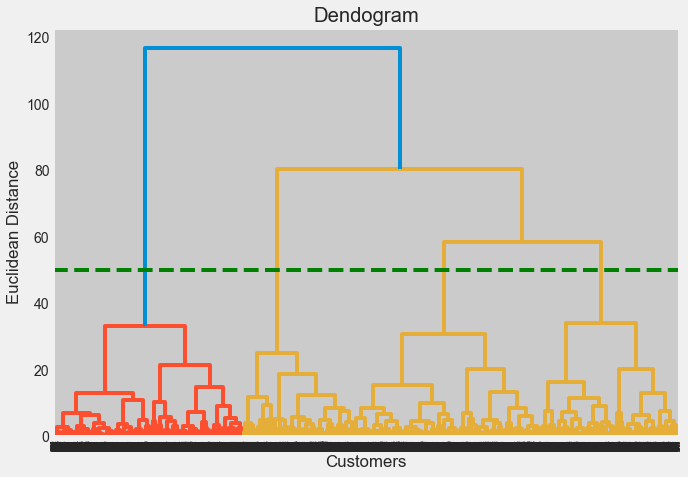

In [526]:
#dendogram with threshold line
plt.figure(figsize=(10,7))
dist = hierarchy.linkage(data_normalized,method='ward')
dendogram = hierarchy.dendrogram(dist)
plt.title('Dendogram')
plt.ylabel('Euclidean Distance')
plt.xlabel('Customers')
plt.axhline(y=50, c='green',linestyle='--');

In [536]:
#run the agglomerative clustering algorithm with 4 clusters and predict, and assign the clusters to data
model_4 = AgglomerativeClustering(n_clusters = 4,affinity='euclidean',linkage='ward')
clusters_4 = model_4.fit_predict(data_normalized)
hier_data_4 = data.assign(Group=clusters_4)

In [545]:
silhouette_score(data_normalized,clusters_4)

0.32270405272024266

In [559]:
#display kmeans dataframe and hierarchical dataframe 

display('hierarchical clusters:', hier_data_4.groupby('Group').agg({
            'Recency':'mean',
            'Frequency':'mean',
            'MonetaryValue':['mean','count']}).round(0),
    'Kmeans clusters: ',group_4.agg({'Recency':'mean',
            'Frequency':'mean',
            'MonetaryValue':['mean','count']}).round(0))
        



'hierarchical clusters:'

Recency Frequency MonetaryValue      
         mean      mean          mean count
Group                                      
0        32.0      56.0         731.0  1251
1       409.0      20.0         264.0  1751
2        19.0     445.0        7290.0  1009
3       216.0     112.0        1787.0  1720

'Kmeans clusters: '

Recency Frequency MonetaryValue      
         mean      mean          mean count
Group                                      
0        31.0      55.0         770.0  1207
1       279.0      88.0        1310.0  1568
2        29.0     395.0        6434.0  1311
3       386.0      15.0         235.0  1645

>The groups from hierarchical and kmeans are similar except that group 3 from kmeans  is similar to group 1 for hierarchical.

In [539]:
#run the agglomerative clustering algorithm with 5 clusters and predict, and assign the clusters to data

model_5 = AgglomerativeClustering(n_clusters = 5,affinity='euclidean',linkage='ward')
clusters_5 = model_5.fit_predict(data_normalized)
hier_data_5 = data.assign(Group=clusters_5)
display(hier_data_5.groupby('Group').agg({
            'Recency':'mean',
            'Frequency':'mean',
            'MonetaryValue':['mean','count']}).round(0))

Recency Frequency MonetaryValue      
         mean      mean          mean count
Group                                      
0       409.0      20.0         264.0  1751
1       216.0     112.0        1787.0  1720
2        19.0     445.0        7290.0  1009
3        48.0      23.0         420.0   584
4        18.0      85.0        1003.0   667

In [546]:
silhouette_score(data_normalized,clusters_5)

0.28630718858957693

>The silhouette score is lower for 5 clusters. The closer the score is to 1 means that the clusters are dense and well separated. Lets look at the plot of the clusters. 

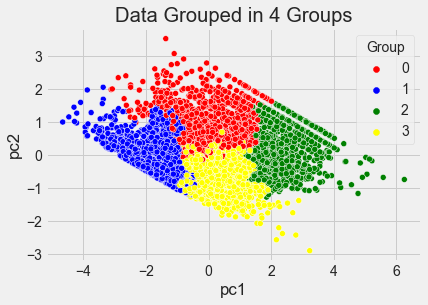

In [502]:
#to view the clusters I will run pca with two coponents and add the clusters
pca_comp_2 = PCA(n_components=2).fit_transform(data_normalized)
pca_df = pd.DataFrame(data=pca_comp_2,columns = ['pc1','pc2'])
pca_df_hier_4 = pca_df.assign(Group=clusters_4)
sns.scatterplot(x='pc1',y='pc2',hue= 'Group',data=pca_df_hier,palette=['red','blue','green','yellow'])
plt.title('Data Grouped in 4 Groups');

>Both clustering algorithms, kmeans and hierarchical give similar results for customer segments.

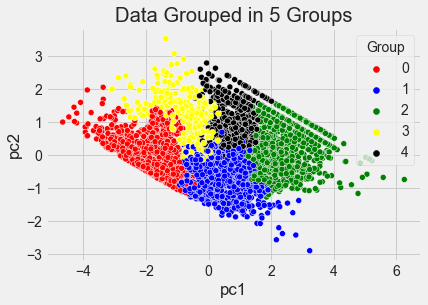

In [543]:
#to view 5 clusters 
pca_comp_2 = PCA(n_components=2).fit_transform(data_normalized)
pca_df = pd.DataFrame(data=pca_comp_2,columns = ['pc1','pc2'])
pca_df_hier_5 = pca_df.assign(Group=clusters_5)
sns.scatterplot(x='pc1',y='pc2',hue= 'Group',data=pca_df_hier_5,palette=['red','blue','green','yellow','black'])
plt.title('Data Grouped in 5 Groups');

>for 5 segments, segment 0 is further segmented into 2 segment, which means that 4 segments are optimal because further segmentation only over fits to the data and does not add a lot more information.

In [561]:
#save data
hier_data_4.to_csv(data_path + '/hierchichal_4_groups.csv')
